In [2]:
import pandas as pd
Gold_df = pd.read_csv('Gold Futures Historical Data-10.csv')

In [3]:
Gold_df = Gold_df.dropna(subset=['Vol.']).reset_index(drop=True)

In [4]:
import pandas as pd

# ✅ Rename columns for simplicity (optional but cleaner)
Gold_df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Vol', 'Change']

# ✅ Convert Date to datetime format and sort ascending
Gold_df['Date'] = pd.to_datetime(Gold_df['Date'])
Gold_df = Gold_df.sort_values('Date')

# ✅ Remove commas and convert price columns to float
for col in ['Close', 'Open', 'High', 'Low']:
    Gold_df[col] = Gold_df[col].replace(',', '', regex=True).astype(float)

# ✅ Convert Volume (Vol) from K/M to numeric values
def convert_volume(vol):
    if isinstance(vol, str):
        if 'K' in vol:
            return float(vol.replace('K', '')) * 1_000
        elif 'M' in vol:
            return float(vol.replace('M', '')) * 1_000_000
        elif vol == '-' or vol.strip() == '':
            return None
        else:
            return float(vol)
    return vol

Gold_df['Vol'] = Gold_df['Vol'].apply(convert_volume)

# ✅ Clean 'Change' column (remove % and convert to float)
Gold_df['Change'] = Gold_df['Change'].str.replace('%', '', regex=True).astype(float)


In [5]:
Gold_df.isnull().sum()

,0
Date,0
Close,0
Open,0
High,0
Low,0
Vol,0
Change,0


In [ ]:
import numpy as np
import pandas as pd
import os, random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
#log caluculation for close price
Gold_df['return'] = np.log(Gold_df['Close'] / Gold_df['Close'].shift(1))
Gold_df = Gold_df.dropna()

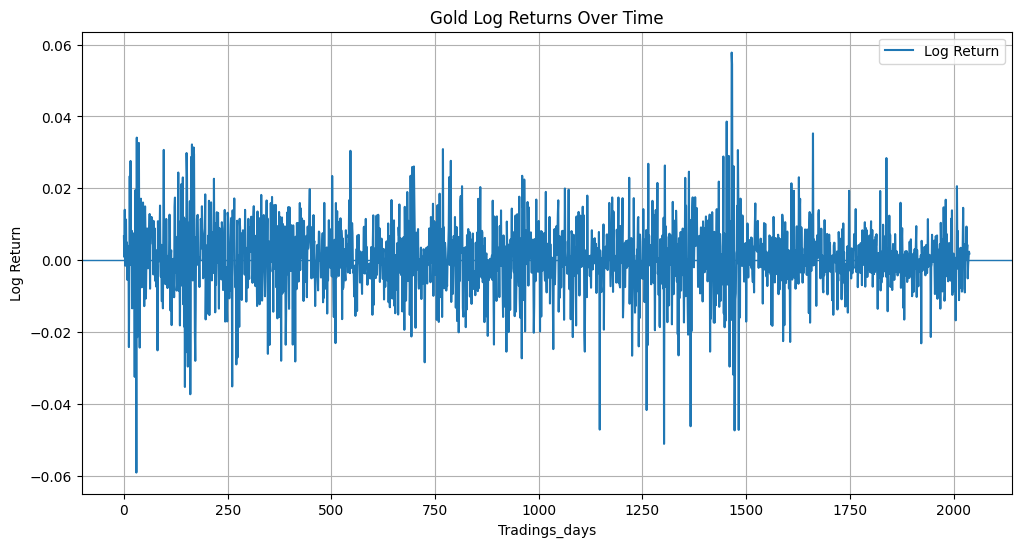

In [ ]:
import matplotlib.pyplot as plt

# Plot log returns
plt.figure(figsize=(12, 6))
plt.plot(Gold_df.index, Gold_df['return'], label='Log Return')
plt.axhline(0, linewidth=1)
plt.title('Gold Log Returns Over Time')
plt.xlabel('Tradings_days')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.savefig('Figure_4_1_Gold_Log_Returns.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.3 MB/s eta 0:00:00


In [ ]:
#Egarch calculation
  from arch import arch_model

model = arch_model(
    Gold_df['return'] * 100,   # scale returns for stability
    vol='EGARCH',
    p=1, o=1, q=1,
    dist='normal'
)

res = model.fit(disp='off')
print(res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2732.51
Distribution:                  Normal   AIC:                           5475.02
Method:            Maximum Likelihood   BIC:                           5503.12
                                        No. Observations:                 2039
Date:                Tue, Jan 06 2026   Df Residuals:                     2038
Time:                        10:16:55   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0443  1.986e-02      2.229  2.580e-02 [5.

In [ ]:
Gold_df['egarch_vol'] = res.conditional_volatility

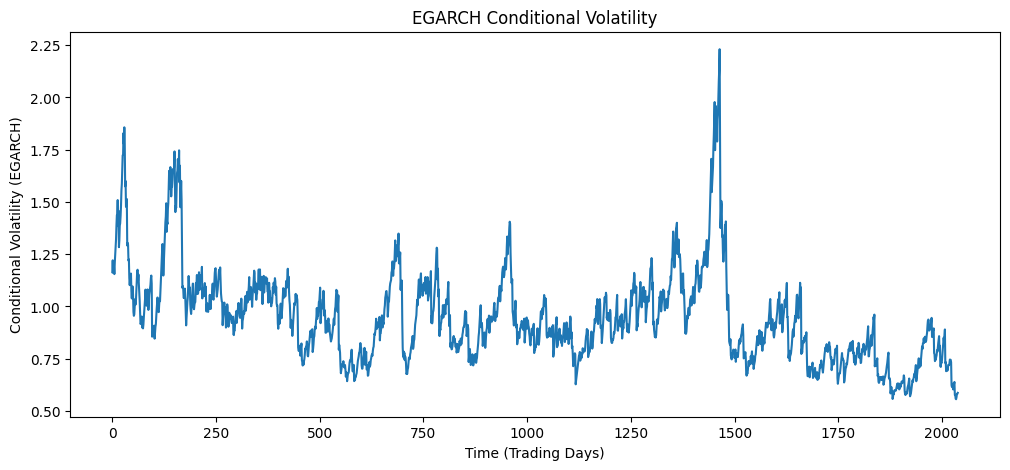

In [ ]:
Gold_df['egarch_vol'].plot(figsize=(12,5), title="EGARCH Conditional Volatility")
plt.xlabel("Time (Trading Days)")
plt.ylabel("Conditional Volatility (EGARCH)")
plt.savefig('Figure_4_2_EGARCH_CONDITIONAL_VOLTILITY.png', dpi=300, bbox_inches='tight')

In [ ]:
import numpy as np
import pandas as pd

# 1. Make sure data is sorted by date
Gold_df = Gold_df.sort_values('Date').reset_index(drop=True)

# 2. Smooth EGARCH volatility (5-day EWM, you can try 7 or 10 later)
Gold_df['egarch_vol_ewm'] = Gold_df['egarch_vol'].ewm(span=7, adjust=False).mean()

# 3. Log-transform the smoothed volatility to stabilise scale
Gold_df['log_egarch_vol_ewm'] = np.log(Gold_df['egarch_vol_ewm'] + 1e-6)

# 4. Keep only non-null rows for these columns
Gold_df = Gold_df.dropna(subset=['Close', 'Vol', 'log_egarch_vol_ewm'])

Gold_df[['Date', 'Close', 'Vol', 'egarch_vol', 'egarch_vol_ewm', 'log_egarch_vol_ewm']].head()

,Date,Close,Vol,egarch_vol,egarch_vol_ewm,log_egarch_vol_ewm
0,2018-01-03,1318.5,353460.0,0.586492,0.586492,-0.533594
1,2018-01-04,1321.6,369850.0,0.581461,0.585234,-0.535741
2,2018-01-05,1322.3,330230.0,0.581163,0.584217,-0.537482
3,2018-01-08,1320.4,246090.0,0.565676,0.579581,-0.545447
4,2018-01-09,1313.7,333530.0,0.556038,0.573695,-0.555655


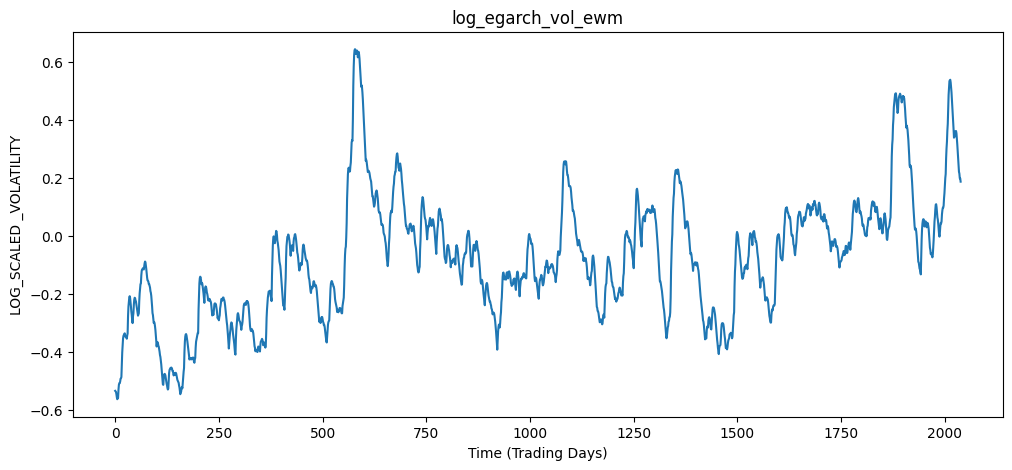

In [ ]:
#smooth EGRACH
Gold_df['log_egarch_vol_ewm'].plot(figsize=(12,5), title="log_egarch_vol_ewm")
plt.xlabel("Time (Trading Days)")
plt.ylabel("LOG_SCALED _VOLATILITY")
plt.savefig('log_egarch_vol_ewm.png', dpi=300, bbox_inches='tight')

In [ ]:
# Make sure Gold_df has 'Close' ,'Vol' ,'Vol','log_egarch_vol_ewm'
data = Gold_df[['Close', 'Vol','log_egarch_vol_ewm']].dropna().values  # shape (N, 3)

window_size = 14   # you can tune this
n = len(data)
print("Total rows:", n)

# Time-based 80/10/10 split
train_end = int(n * 0.8)
val_end   = int(n * 0.9)

train_raw = data[:train_end]
val_raw   = data[train_end - window_size : val_end]   # include overlap
test_raw  = data[val_end - window_size :]             # include overlap

print("Train raw:", train_raw.shape)
print("Val raw  :", val_raw.shape)
print("Test raw :", test_raw.shape)

Total rows: 2039
Train raw: (1631, 3)
Val raw  : (218, 3)
Test raw : (218, 3)


In [ ]:
def create_sequences(X_data, y_data, window_size=14):
    """
    X_data: (N, n_features)
    y_data: (N, 1)
    Returns:
      X: (num_samples, window_size, n_features)
      y: (num_samples, 1)
    """
    X, y = [], []
    for i in range(window_size, len(X_data)):
        X.append(X_data[i-window_size:i])
        y.append(y_data[i])
    return np.array(X), np.array(y)

In [ ]:
# Feature scaler (Close + Vol +'log_egarch_vol_ewm')
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_raw)
X_val_scaled   = X_scaler.transform(val_raw)
X_test_scaled  = X_scaler.transform(test_raw)

# Target scaler (Close only)
y_scaler = MinMaxScaler()

close_train = train_raw[:, 0].reshape(-1, 1)
close_val   = val_raw[:, 0].reshape(-1, 1)
close_test  = test_raw[:, 0].reshape(-1, 1)

y_train_scaled_full = y_scaler.fit_transform(close_train)
y_val_scaled_full   = y_scaler.transform(close_val)
y_test_scaled_full  = y_scaler.transform(close_test)

In [ ]:
X_tr, y_tr = create_sequences(X_train_scaled, y_train_scaled_full, window_size)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled_full, window_size)
X_te, y_te = create_sequences(X_test_scaled, y_test_scaled_full, window_size)

print("Train seq:", X_tr.shape, y_tr.shape)
print("Val seq  :", X_val.shape, y_val.shape)
print("Test seq :", X_te.shape, y_te.shape)

Train seq: (1617, 14, 3) (1617, 1)
Val seq  : (204, 14, 3) (204, 1)
Test seq : (204, 14, 3) (204, 1)


In [ ]:
# Feature scaler ((Close + Vol +'log_egarch_vol_ewm')
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_raw)
X_val_scaled   = X_scaler.transform(val_raw)
X_test_scaled  = X_scaler.transform(test_raw)

# Target scaler (Close only)
y_scaler = MinMaxScaler()

close_train = train_raw[:, 0].reshape(-1, 1)
close_val   = val_raw[:, 0].reshape(-1, 1)
close_test  = test_raw[:, 0].reshape(-1, 1)

y_train_scaled_full = y_scaler.fit_transform(close_train)
y_val_scaled_full   = y_scaler.transform(close_val)
y_test_scaled_full  = y_scaler.transform(close_test)

In [ ]:
# Number of models in the ensemble
num_models = 10

# Auto-generate different random seeds each time you run this cell
seeds = np.random.randint(1, 100000, num_models)
print("Using seeds:", seeds)

ensemble_preds = []
metrics = []

for i, s in enumerate(seeds, start=1):
    print(f"\n===== Training ensemble member {i}/{num_models} with seed {s} =====\n")

    mae, rmse, y_true, y_pred = train_lstm_once(
        X_tr, y_tr, X_val, y_val, X_te, y_te, y_scaler,
        epochs=30,
        batch_size=32,
        seed=s        # DIFFERENT SEED EACH RUN
    )

    print(f"\nSeed {s} → MAE = {mae:.2f}, RMSE = {rmse:.2f}\n")

    ensemble_preds.append(y_pred)
    metrics.append((mae, rmse))

ensemble_preds = np.stack(ensemble_preds, axis=0)   # (num_models, n_test, 1)
metrics = np.array(metrics)

Using seeds: [18970  9369 13244 76201 43658  4005 43662 17374 14898 77467]

===== Training ensemble member 1/10 with seed 18970 =====



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0064 - mae: 0.0654 - val_loss: 0.0135 - val_mae: 0.0955
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0305 - mae: 0.1489 - val_loss: 0.0066 - val_mae: 0.0686
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0128 - mae: 0.0964 - val_loss: 0.0037 - val_mae: 0.0504
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 0.0048 - val_mae: 0.0556
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 0.0052 - val_mae: 0.0577
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0046 - val_mae: 0.0544
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0032 - val_mae: 0.0452
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.070

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0055 - mae: 0.0610 - val_loss: 0.0104 - val_mae: 0.0834
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0092 - mae: 0.0825 - val_loss: 0.0058 - val_mae: 0.0623
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0119 - mae: 0.0930 - val_loss: 0.0037 - val_mae: 0.0507
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0076 - mae: 0.0729 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038 - mae: 0.0508 - val_loss: 0.0022 - val_mae: 0.0386
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0219e-04 - mae: 0.0214 - val_loss: 0.0031 - val_mae: 0.0453
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2232e-04 - mae: 0.0163 - val_loss: 0.0033 - val_mae: 0.0471
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.8639e-04 - mae: 0.0198 - val_loss: 0.0021 - val_mae: 0.0371
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0056 - mae: 0.0614 - val_loss: 0.0086 - val_mae: 0.0755
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0163 - mae: 0.1095 - val_loss: 0.0119 - val_mae: 0.0880
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0160 - mae: 0.1076 - val_loss: 0.0055 - val_mae: 0.0626
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0124 - mae: 0.0940 - val_loss: 0.0021 - val_mae: 0.0380
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - mae: 0.0297 - val_loss: 0.0033 - val_mae: 0.0470
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0327 - val_loss: 0.0032 - val_mae: 0.0461
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0274 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8754e-04 - mae: 0.0197 - val_loss: 0.0026 - val_mae: 0.0412
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0060 - mae: 0.0620 - val_loss: 0.0091 - val_mae: 0.0777
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0173 - mae: 0.1118 - val_loss: 0.0092 - val_mae: 0.0771
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0086 - mae: 0.0784 - val_loss: 0.0047 - val_mae: 0.0562
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0036 - mae: 0.0486 - val_loss: 0.0044 - val_mae: 0.0538
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0284 - val_loss: 0.0069 - val_mae: 0.0663
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6469e-04 - mae: 0.0241 - val_loss: 0.0064 - val_mae: 0.0638
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.8290e-04 - mae: 0.0209 - val_loss: 0.0053 - val_mae: 0.0583
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.8630e-04 - mae: 0.0212 - val_loss: 0.0044 - val_mae: 0.0530
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0087 - mae: 0.0745 - val_loss: 0.0129 - val_mae: 0.0960
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0338 - mae: 0.1544 - val_loss: 0.0073 - val_mae: 0.0728
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0260 - mae: 0.1375 - val_loss: 0.0046 - val_mae: 0.0576
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - mae: 0.0774 - val_loss: 0.0029 - val_mae: 0.0446
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - mae: 0.0513 - val_loss: 0.0041 - val_mae: 0.0512
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010 - mae: 0.0232 - val_loss: 0.0039 - val_mae: 0.0512
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - mae: 0.0258 - val_loss: 0.0042 - val_mae: 0.0542
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - mae: 0.0225 - val_loss: 0.0038 - val_mae: 0.0516
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.422

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0072 - mae: 0.0685 - val_loss: 0.0064 - val_mae: 0.0665
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0178 - mae: 0.1143 - val_loss: 0.0048 - val_mae: 0.0593
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0098 - mae: 0.0825 - val_loss: 0.0038 - val_mae: 0.0519
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mae: 0.0400 - val_loss: 0.0029 - val_mae: 0.0433
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9418e-04 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0512
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5334e-04 - mae: 0.0188 - val_loss: 0.0043 - val_mae: 0.0530
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7417e-04 - mae: 0.0210 - val_loss: 0.0035 - val_mae: 0.0478
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.1070e-04 - mae: 0.0218 - val_loss: 0.0029 - val_mae: 0.0437
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/st

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0070 - mae: 0.0700 - val_loss: 0.0074 - val_mae: 0.0712
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0226 - mae: 0.1256 - val_loss: 0.0062 - val_mae: 0.0676
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0131 - mae: 0.0965 - val_loss: 0.0037 - val_mae: 0.0514
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0392 - val_loss: 0.0045 - val_mae: 0.0543
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - mae: 0.0383 - val_loss: 0.0045 - val_mae: 0.0548
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - mae: 0.0248 - val_loss: 0.0037 - val_mae: 0.0504
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0026 - val_mae: 0.0420
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0021 - val_mae: 0.0373
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.706

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0051 - mae: 0.0583 - val_loss: 0.0104 - val_mae: 0.0821
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0121 - mae: 0.0941 - val_loss: 0.0079 - val_mae: 0.0719
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0149 - mae: 0.1041 - val_loss: 0.0039 - val_mae: 0.0512
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - mae: 0.0574 - val_loss: 0.0032 - val_mae: 0.0467
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0309 - val_loss: 0.0042 - val_mae: 0.0523
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.4766e-04 - mae: 0.0189 - val_loss: 0.0045 - val_mae: 0.0542
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.2139e-04 - mae: 0.0214 - val_loss: 0.0035 - val_mae: 0.0483
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.1747e-04 - mae: 0.0235 - val_loss: 0.0022 - val_mae: 0.0376
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0063 - mae: 0.0640 - val_loss: 0.0065 - val_mae: 0.0659
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0252 - mae: 0.1357 - val_loss: 0.0046 - val_mae: 0.0584
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0101 - mae: 0.0868 - val_loss: 0.0039 - val_mae: 0.0532
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - mae: 0.0513 - val_loss: 0.0021 - val_mae: 0.0371
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.6586e-04 - mae: 0.0254 - val_loss: 0.0032 - val_mae: 0.0462
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.2466e-04 - mae: 0.0211 - val_loss: 0.0024 - val_mae: 0.0406
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.3943e-04 - mae: 0.0234 - val_loss: 0.0020 - val_mae: 0.0374
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4803e-04 - mae: 0.0219 - val_loss: 0.0018 - val_mae: 0.0345
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/st

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0078 - mae: 0.0702 - val_loss: 0.0108 - val_mae: 0.0839
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0230 - mae: 0.1259 - val_loss: 0.0047 - val_mae: 0.0551
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - mae: 0.0678 - val_loss: 0.0035 - val_mae: 0.0472
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - mae: 0.0281 - val_loss: 0.0038 - val_mae: 0.0498
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7231e-04 - mae: 0.0196 - val_loss: 0.0032 - val_mae: 0.0453
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2763e-04 - mae: 0.0184 - val_loss: 0.0020 - val_mae: 0.0358
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.6203e-04 - mae: 0.0237 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step -

**The following section focuses on the design, implementation, and training of the Bidirectional Long Short-Term Memory (BiLSTM) model used in this study.**

In [ ]:
import numpy as np
import pandas as pd
import os, random

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

import matplotlib.pyplot as plt

In [ ]:
# Make sure Gold_df has 'Close' , 'Vol','log_egarch_vol_ewm'
data = Gold_df[['Close', 'Vol','log_egarch_vol_ewm']].dropna().values  # shape (N, 3)

window_size = 14   # you can tune this
n = len(data)
print("Total rows:", n)

# Time-based 80/10/10 split
train_end = int(n * 0.8)
val_end   = int(n * 0.9)

train_raw = data[:train_end]
val_raw   = data[train_end - window_size : val_end]   # include overlap
test_raw  = data[val_end - window_size :]             # include overlap

print("Train raw:", train_raw.shape)
print("Val raw  :", val_raw.shape)
print("Test raw :", test_raw.shape)

Total rows: 2039
Train raw: (1631, 3)
Val raw  : (218, 3)
Test raw : (218, 3)


In [ ]:
def create_sequences(X_data, y_data, window_size=14):
    """
    X_data: (N, n_features)
    y_data: (N, 1)
    Returns:
      X: (num_samples, window_size, n_features)
      y: (num_samples, 1)
    """
    X, y = [], []
    for i in range(window_size, len(X_data)):
        X.append(X_data[i-window_size:i])
        y.append(y_data[i])
    return np.array(X), np.array(y)

In [ ]:
# Feature scaler (Close + Vol)
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_raw)
X_val_scaled   = X_scaler.transform(val_raw)
X_test_scaled  = X_scaler.transform(test_raw)

# Target scaler (Close only)
y_scaler = MinMaxScaler()

close_train = train_raw[:, 0].reshape(-1, 1)
close_val   = val_raw[:, 0].reshape(-1, 1)
close_test  = test_raw[:, 0].reshape(-1, 1)

y_train_scaled_full = y_scaler.fit_transform(close_train)
y_val_scaled_full   = y_scaler.transform(close_val)
y_test_scaled_full  = y_scaler.transform(close_test)

In [ ]:
X_tr, y_tr = create_sequences(X_train_scaled, y_train_scaled_full, window_size)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled_full, window_size)
X_te, y_te = create_sequences(X_test_scaled, y_test_scaled_full, window_size)

print("Train seq:", X_tr.shape, y_tr.shape)
print("Val seq  :", X_val.shape, y_val.shape)
print("Test seq :", X_te.shape, y_te.shape)

Train seq: (1617, 14, 3) (1617, 1)
Val seq  : (204, 14, 3) (204, 1)
Test seq : (204, 14, 3) (204, 1)


In [ ]:
# Feature scaler (Close + Vol,EGARCH)
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_raw)
X_val_scaled   = X_scaler.transform(val_raw)
X_test_scaled  = X_scaler.transform(test_raw)

# Target scaler (Close only)
y_scaler = MinMaxScaler()

close_train = train_raw[:, 0].reshape(-1, 1)
close_val   = val_raw[:, 0].reshape(-1, 1)
close_test  = test_raw[:, 0].reshape(-1, 1)

y_train_scaled_full = y_scaler.fit_transform(close_train)
y_val_scaled_full   = y_scaler.transform(close_val)
y_test_scaled_full  = y_scaler.transform(close_test)

In [ ]:
def train_lstm_once(
    X_tr, y_tr, X_val, y_val, X_te, y_te, y_scaler,
    epochs=30, batch_size=32, seed=None
):
    tf.keras.backend.clear_session()

    if seed is not None:
        seed = int(seed)   # FIX

        np.random.seed(seed)
        random.seed(seed)
        tf.random.set_seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        os.environ["TF_DETERMINISTIC_OPS"] = "1"

    # ==== CHANGED ONLY THIS PART (LSTM → Bidirectional LSTM) ====
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=False),
                      input_shape=(X_tr.shape[1], X_tr.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    # =============================================================

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        verbose=1
    )

    y_pred_scaled = model.predict(X_te, verbose=0)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_te)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return mae, rmse, y_true, y_pred

In [ ]:
# Number of models in the ensemble
num_models = 10

# Auto-generate different random seeds each time you run this cell
seeds = np.random.randint(1, 100000, num_models)
print("Using seeds:", seeds)

ensemble_preds = []
metrics = []

for i, s in enumerate(seeds, start=1):
    print(f"\n===== Training ensemble member {i}/{num_models} with seed {s} =====\n")

    mae, rmse, y_true, y_pred = train_lstm_once(
        X_tr, y_tr, X_val, y_val, X_te, y_te, y_scaler,
        epochs=30,
        batch_size=32,
        seed=s        # DIFFERENT SEED EACH RUN
    )

    print(f"\nSeed {s} → MAE = {mae:.2f}, RMSE = {rmse:.2f}\n")

    ensemble_preds.append(y_pred)
    metrics.append((mae, rmse))

ensemble_preds = np.stack(ensemble_preds, axis=0)   # (num_models, n_test, 1)
metrics = np.array(metrics)

Using seeds: [99422 50101 11099 53206 26928 96705 61019 23395 83472 67089]

===== Training ensemble member 1/10 with seed 99422 =====



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0072 - mae: 0.0695 - val_loss: 0.0086 - val_mae: 0.0745
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0101 - mae: 0.0835 - val_loss: 0.0059 - val_mae: 0.0623
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094 - mae: 0.0797 - val_loss: 0.0040 - val_mae: 0.0518
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0040 - mae: 0.0505 - val_loss: 0.0031 - val_mae: 0.0453
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.4472e-04 - mae: 0.0220 - val_loss: 0.0020 - val_mae: 0.0363
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - mae: 0.0304 - val_loss: 0.0021 - val_mae: 0.0365
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - mae: 0.0338 - val_loss: 0.0032 - val_mae: 0.0451
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 0.0046 - val_mae: 0.0557
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0095 - mae: 0.0761 - val_loss: 0.0089 - val_mae: 0.0781
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0217 - mae: 0.1228 - val_loss: 0.0076 - val_mae: 0.0707
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0108 - mae: 0.0865 - val_loss: 0.0042 - val_mae: 0.0547
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0049 - mae: 0.0566 - val_loss: 0.0032 - val_mae: 0.0465
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9759e-04 - mae: 0.0238 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.9379e-04 - mae: 0.0202 - val_loss: 0.0029 - val_mae: 0.0430
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0021 - val_mae: 0.0373
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0314 - val_loss: 0.0022 - val_mae: 0.0378
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0080 - mae: 0.0732 - val_loss: 0.0050 - val_mae: 0.0583
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0134 - mae: 0.0967 - val_loss: 0.0049 - val_mae: 0.0572
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - mae: 0.0670 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6183e-04 - mae: 0.0244 - val_loss: 0.0020 - val_mae: 0.0372
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0021 - val_mae: 0.0364
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - mae: 0.0350 - val_loss: 0.0018 - val_mae: 0.0347
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - mae: 0.0327 - val_loss: 0.0018 - val_mae: 0.0349
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0095 - mae: 0.0762 - val_loss: 0.0069 - val_mae: 0.0683
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0154 - mae: 0.1038 - val_loss: 0.0050 - val_mae: 0.0606
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0088 - mae: 0.0773 - val_loss: 0.0039 - val_mae: 0.0529
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 0.0025 - val_mae: 0.0407
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.8746e-04 - mae: 0.0229 - val_loss: 0.0030 - val_mae: 0.0436
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.3396e-04 - mae: 0.0210 - val_loss: 0.0025 - val_mae: 0.0396
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0011 - mae: 0.0258 - val_loss: 0.0021 - val_mae: 0.0371
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011 - mae: 0.0251 - val_loss: 0.0020 - val_mae: 0.0359
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0053 - mae: 0.0601 - val_loss: 0.0100 - val_mae: 0.0802
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108 - mae: 0.0872 - val_loss: 0.0052 - val_mae: 0.0593
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060 - mae: 0.0607 - val_loss: 0.0039 - val_mae: 0.0507
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - mae: 0.0258 - val_loss: 0.0020 - val_mae: 0.0360
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 0.0019 - val_mae: 0.0350
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - mae: 0.0346 - val_loss: 0.0016 - val_mae: 0.0324
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0018 - mae: 0.0342 - val_loss: 0.0014 - val_mae: 0.0296
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018 - mae: 0.0344 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.001

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0058 - mae: 0.0623 - val_loss: 0.0090 - val_mae: 0.0762
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0088 - mae: 0.0800 - val_loss: 0.0041 - val_mae: 0.0529
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0058 - mae: 0.0630 - val_loss: 0.0031 - val_mae: 0.0456
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - mae: 0.0302 - val_loss: 0.0024 - val_mae: 0.0394
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - mae: 0.0305 - val_loss: 0.0023 - val_mae: 0.0391
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - mae: 0.0297 - val_loss: 0.0021 - val_mae: 0.0362
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - mae: 0.0304 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - mae: 0.0325 - val_loss: 0.0013 - val_mae: 0.0294
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.001

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0090 - mae: 0.0748 - val_loss: 0.0140 - val_mae: 0.0993
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0365 - mae: 0.1604 - val_loss: 0.0071 - val_mae: 0.0718
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0141 - mae: 0.0951 - val_loss: 0.0056 - val_mae: 0.0622
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0077 - mae: 0.0742 - val_loss: 0.0026 - val_mae: 0.0419
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - mae: 0.0337 - val_loss: 0.0033 - val_mae: 0.0455
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0031 - val_mae: 0.0438
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - mae: 0.0325 - val_loss: 0.0024 - val_mae: 0.0386
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0015 - mae: 0.0291 - val_loss: 0.0021 - val_mae: 0.0362
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.001

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0052 - mae: 0.0597 - val_loss: 0.0132 - val_mae: 0.0932
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0076 - mae: 0.0725 - val_loss: 0.0052 - val_mae: 0.0591
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0084 - mae: 0.0753 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - mae: 0.0437 - val_loss: 0.0022 - val_mae: 0.0382
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0578e-04 - mae: 0.0214 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - mae: 0.0299 - val_loss: 0.0023 - val_mae: 0.0384
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0017 - mae: 0.0326 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0069 - mae: 0.0672 - val_loss: 0.0051 - val_mae: 0.0594
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0157 - mae: 0.1074 - val_loss: 0.0046 - val_mae: 0.0575
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0142 - mae: 0.0955 - val_loss: 0.0031 - val_mae: 0.0460
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.8692e-04 - mae: 0.0239 - val_loss: 0.0041 - val_mae: 0.0515
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.0115e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0368
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0353
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - mae: 0.0341 - val_loss: 0.0017 - val_mae: 0.0339
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0047 - mae: 0.0541 - val_loss: 0.0047 - val_mae: 0.0553
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0036 - mae: 0.0491 - val_loss: 0.0018 - val_mae: 0.0354
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - mae: 0.0423 - val_loss: 0.0029 - val_mae: 0.0438
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.8299e-04 - mae: 0.0200 - val_loss: 0.0016 - val_mae: 0.0327
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.5998e-04 - mae: 0.0226 - val_loss: 0.0015 - val_mae: 0.0323
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.3872e-04 - mae: 0.0220 - val_loss: 0.0019 - val_mae: 0.0348
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - mae: 0.0324 - val_loss: 0.0020 - val_mae: 0.0344
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - mae: 0.0320 - val_loss: 0.0024 - val_mae: 0.0383
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step -

In [13]:
#Chronological splitting of the gold price time series into training,
#validation, and testing subsets using an 80–10–10 ratio.

import pandas as pd

# Ensure datetime index
Gold_df = Gold_df.sort_index()
if not pd.api.types.is_datetime64_any_dtype(Gold_df.index):
    Gold_df.index = pd.to_datetime(Gold_df.index)

# Dataset length
N = len(Gold_df)

# Split indices (80% train, 10% validation, 10% test)
train_end = int(0.8 * N)
val_end = int(0.9 * N)

# Training period
train_start_date = Gold_df.index[0]
train_end_date = Gold_df.index[train_end - 1]

# Validation period
val_start_date = Gold_df.index[train_end]
val_end_date = Gold_df.index[val_end - 1]

# Test / prediction period
test_start_date = Gold_df.index[val_end]
test_end_date = Gold_df.index[-1]

# Display date ranges
print("Training period:", train_start_date, "to", train_end_date)
print("Validation period:", val_start_date, "to", val_end_date)
print("Test/Prediction period:", test_start_date, "to", test_end_date)


Training period: 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000001631
Validation period: 1970-01-01 00:00:00.000001632 to 1970-01-01 00:00:00.000001835
Test/Prediction period: 1970-01-01 00:00:00.000001836 to 1970-01-01 00:00:00.000002039


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# LSTM–EGARCH results (10 seeds)
# ==============================

# batch of 10 (earlier)
lstm_mae = np.array([82.34, 102.37, 157.16, 190.59, 67.52, 121.15, 58.84, 84.00, 59.55, 60.21])
lstm_rmse = np.array([111.72, 132.16, 194.52, 229.84, 87.89, 155.64, 72.73, 113.29, 72.70, 78.54])


lstm_mae = np.concatenate([lstm_mae])
lstm_rmse = np.concatenate([lstm_rmse])

# ==============================
# BiLSTM–EGARCH results (10 seeds)
# ==============================

# batch of 10 (just now)
bilstm_mae = np.array([92.12, 56.22, 125.14, 53.60, 81.49, 65.76, 82.20, 56.64, 52.79, 87.87])
bilstm_rmse = np.array([110.95, 69.80, 143.49, 68.45, 97.53, 80.98, 111.84, 74.58, 65.98, 103.27])

bilstm_mae = np.concatenate([bilstm_mae])
bilstm_rmse = np.concatenate([bilstm_rmse])


In [7]:
#summary of LSTM & BILSM performace across alst 10 runs

def summarize_model(name, mae_arr, rmse_arr):
    return {
        "Model": name,
        "MAE_mean": mae_arr.mean(),
        "MAE_std": mae_arr.std(),
        "MAE_min": mae_arr.min(),
        "MAE_max": mae_arr.max(),
        "RMSE_mean": rmse_arr.mean(),
        "RMSE_std": rmse_arr.std(),
        "RMSE_min": rmse_arr.min(),
        "RMSE_max": rmse_arr.max(),
    }

lstm_summary   = summarize_model("LSTM_EGARCH", lstm_mae, lstm_rmse)
bilstm_summary = summarize_model("BiLSTM_EGARCH", bilstm_mae, bilstm_rmse)

df_summary = pd.DataFrame([lstm_summary, bilstm_summary])
print(df_summary)


           Model  MAE_mean    MAE_std  MAE_min  MAE_max  RMSE_mean   RMSE_std  \
0    LSTM_EGARCH    98.373  42.937979    58.84   190.59    124.903  51.118535   
1  BiLSTM_EGARCH    75.383  21.889824    52.79   125.14     92.687  23.887658   

   RMSE_min  RMSE_max  
0     72.70    229.84  
1     65.98    143.49  


/tmp/ipython-input-4014468197.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([lstm_mae, bilstm_mae], labels=["LSTM–EGARCH", "BiLSTM–EGARCH"])
/tmp/ipython-input-4014468197.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([lstm_rmse, bilstm_rmse], labels=["LSTM–EGARCH", "BiLSTM–EGARCH"])


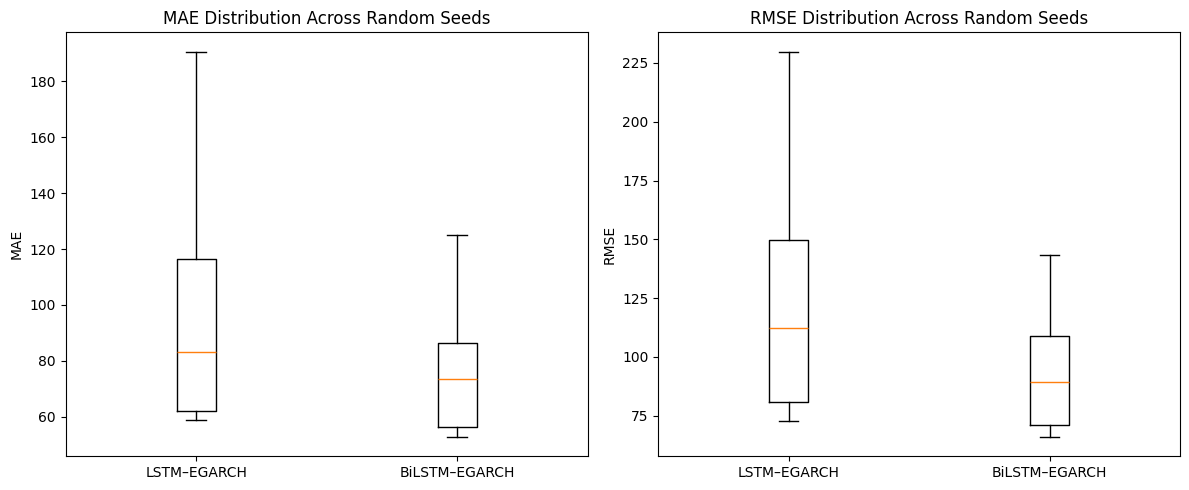

In [8]:
#Box plot for LSTM-EGARCH & BILSTM-EGARCH

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MAE boxplot
axes[0].boxplot([lstm_mae, bilstm_mae], labels=["LSTM–EGARCH", "BiLSTM–EGARCH"])
axes[0].set_title("MAE Distribution Across Random Seeds")
axes[0].set_ylabel("MAE")

# RMSE boxplot
axes[1].boxplot([lstm_rmse, bilstm_rmse], labels=["LSTM–EGARCH", "BiLSTM–EGARCH"])
axes[1].set_title("RMSE Distribution Across Random Seeds")
axes[1].set_ylabel("RMSE")

plt.tight_layout()
plt.show()


In [ ]:
# Best seeds by MAE (within the 20 values you gave)
best_lstm_idx = np.argmin(lstm_mae)
best_bilstm_idx = np.argmin(bilstm_mae)

print("Best LSTM-EGARCH run:")
print("  MAE  =", lstm_mae[best_lstm_idx])
print("  RMSE =", lstm_rmse[best_lstm_idx])

print("\nBest BiLSTM-EGARCH run:")
print("  MAE  =", bilstm_mae[best_bilstm_idx])
print("  RMSE =", bilstm_rmse[best_bilstm_idx])


Best LSTM-EGARCH run:
  MAE  = 58.84
  RMSE = 72.73

Best BiLSTM-EGARCH run:
  MAE  = 52.79
  RMSE = 65.98


**One-day-ahead forecasting using the selected BiLSTM-EGARCH model begins here.**

In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
import numpy as np
import pandas as pd
import os, random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam


# ============================================
# 1. CONFIG
# ============================================
window_size = 14                 # chosen from your analysis
train_ratio = 0.8
val_ratio   = 0.1                # test will be 0.1
BEST_SEED   = 83472               # best BiLSTM-EGARCH seed from your experiments

# ============================================
# 2. PREPARE DATA (Gold_df)
#  - Assumes Gold_df has columns: Date (optional), Close, Vol, log_egarch_vol_ewm
# ============================================

# If Date is a column, set as index
if 'Date' in Gold_df.columns:
    Gold_df['Date'] = pd.to_datetime(Gold_df['Date'])
    Gold_df = Gold_df.set_index('Date')

Gold_df = Gold_df.sort_index()

# Features used in the model
feature_cols = ['Close', 'Vol', 'log_egarch_vol_ewm']

# Clean modeling DataFrame
df_model = Gold_df[feature_cols].dropna().copy()
print("Data used for modeling:", df_model.shape)
print(df_model.head())

# ============================================
# 3. TRAIN / VALIDATION / TEST SPLIT (TIME-BASED)
# ============================================
n = len(df_model)
train_end = int(n * train_ratio)
val_end   = int(n * (train_ratio + val_ratio))

print("Total rows:", n)
print("Train end index:", train_end)
print("Val end index  :", val_end)

# Overlap window_size rows for val/test so we can build sequences
train_raw = df_model.iloc[:train_end].values
val_raw   = df_model.iloc[train_end - window_size : val_end].values
test_raw  = df_model.iloc[val_end - window_size :].values

print("Train raw:", train_raw.shape)
print("Val raw  :", val_raw.shape)
print("Test raw :", test_raw.shape)

# ============================================
# 4. SCALING (FEATURES + TARGET)
# ============================================

# Feature scaler (all features, including Close)
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_raw)
X_val_scaled   = X_scaler.transform(val_raw)
X_test_scaled  = X_scaler.transform(test_raw)

# Target scaler (Close only, column 0)
y_scaler = MinMaxScaler()
close_train = train_raw[:, 0].reshape(-1, 1)
close_val   = val_raw[:, 0].reshape(-1, 1)
close_test  = test_raw[:, 0].reshape(-1, 1)

y_train_scaled_full = y_scaler.fit_transform(close_train)
y_val_scaled_full   = y_scaler.transform(close_val)
y_test_scaled_full  = y_scaler.transform(close_test)

# ============================================
# 5. CREATE SEQUENCES
# ============================================
def create_sequences(X_data, y_data, window_size=14):
    """
    X_data: (N, n_features)
    y_data: (N, 1)
    Returns:
      X: (num_samples, window_size, n_features)
      y: (num_samples, 1)
    """
    X, y = [], []
    for i in range(window_size, len(X_data)):
        X.append(X_data[i-window_size:i])
        y.append(y_data[i])
    return np.array(X), np.array(y)

X_tr, y_tr = create_sequences(X_train_scaled, y_train_scaled_full, window_size)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled_full, window_size)
X_te, y_te = create_sequences(X_test_scaled, y_test_scaled_full, window_size)

print("Train seq:", X_tr.shape, y_tr.shape)
print("Val seq  :", X_val.shape, y_val.shape)
print("Test seq :", X_te.shape, y_te.shape)

# ============================================
# 6. BILSTM-EGARCH MODEL (SIMPLE, VALIDATED VERSION)
# ============================================
def build_bilstm_model(input_shape, units=64, dense_units=32, lr=1e-3):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=False),
                      input_shape=input_shape),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics=['mae'])
    return model

def train_bilstm_once(
    X_tr, y_tr, X_val, y_val, X_te, y_te, y_scaler,
    epochs=30, batch_size=32, seed=None,
    units=64, dense_units=32, lr=1e-3
):
    # Clear previous graph
    tf.keras.backend.clear_session()

    # Seed everything for reproducibility
    if seed is not None:
        seed = int(seed)
        np.random.seed(seed)
        random.seed(seed)
        tf.random.set_seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        os.environ["TF_DETERMINISTIC_OPS"] = "1"

    input_shape = (X_tr.shape[1], X_tr.shape[2])
    model = build_bilstm_model(input_shape, units=units,
                               dense_units=dense_units, lr=lr)

    print(model.summary())

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        verbose=1
    )

    # Predict on test set (scaled)
    y_pred_scaled = model.predict(X_te, verbose=0)
    # Inverse transform to original Close scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_te)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"\nFINAL TEST MAE  : {mae:.4f}")
    print(f"FINAL TEST RMSE : {rmse:.4f}")

    return model, mae, rmse, y_true, y_pred

# ============================================
# 7. TRAIN FINAL MODEL WITH BEST SEED
# ============================================
best_model, best_mae, best_rmse, y_true, y_pred = train_bilstm_once(
    X_tr, y_tr,
    X_val, y_val,
    X_te, y_te,
    y_scaler,
    epochs=30,
    batch_size=32,
    seed=BEST_SEED,
    units=64,
    dense_units=32,
    lr=1e-3
)

print("Best seed:", BEST_SEED)
print("Best-model MAE :", best_mae)
print("Best-model RMSE:", best_rmse)

# ============================================
# 8. OPTIONAL: ENSEMBLE OF SEEDS (IF YOU WANT)
# ============================================
# Uncomment this block if you want to run an ensemble.

"""
ensemble_seeds = [9792, 31545, 738]  # example: pick seeds you liked
ensemble_preds = []
ensemble_metrics = []

for s in ensemble_seeds:
    print(f"\n===== Training ensemble member (seed={s}) =====")
    model_e, mae_e, rmse_e, y_true_e, y_pred_e = train_bilstm_once(
        X_tr, y_tr, X_val, y_val, X_te, y_te, y_scaler,
        epochs=30, batch_size=32, seed=s
    )
    ensemble_preds.append(y_pred_e)
    ensemble_metrics.append((mae_e, rmse_e))

ensemble_preds = np.stack(ensemble_preds, axis=0)  # (n_models, n_test, 1)
ensemble_metrics = np.array(ensemble_metrics)

print("\nIndividual ensemble metrics (MAE, RMSE):")
print(ensemble_metrics)
print("Mean MAE :", ensemble_metrics[:,0].mean())
print("Mean RMSE:", ensemble_metrics[:,1].mean())

# Mean ensemble prediction
ensemble_mean_pred = ensemble_preds.mean(axis=0)
ensemble_mae = mean_absolute_error(y_true, ensemble_mean_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_true, ensemble_mean_pred))
print("\nEnsemble mean prediction MAE :", ensemble_mae)
print("Ensemble mean prediction RMSE:", ensemble_rmse)
"""

# ============================================
# 9. 1-DAY AHEAD FORECAST FUNCTION
# ============================================
def forecast_next_day_close(model, Gold_df, feature_cols, X_scaler, y_scaler, window_size=14):
    """
    Uses the last `window_size` rows of Gold_df[feature_cols] to predict
    the next-day Close price.
    """
    df_latest = Gold_df[feature_cols].dropna().copy()
    latest_features = df_latest.tail(window_size).values

    # Scale with training feature scaler
    latest_scaled = X_scaler.transform(latest_features)

    # Reshape to (1, window_size, n_features)
    X_input = latest_scaled.reshape(1, window_size, -1)

    # Predict scaled Close
    y_pred_scaled = model.predict(X_input, verbose=0)

    # Inverse transform to original Close
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    return float(y_pred[0, 0])

# Example: get next-day forecast from best_model
next_close_pred = forecast_next_day_close(
    best_model,
    Gold_df,
    feature_cols,
    X_scaler,
    y_scaler,
    window_size=window_size
)

print("\nPredicted next-day Close:", next_close_pred)

Data used for modeling: (2039, 3)
             Close       Vol  log_egarch_vol_ewm
Date                                            
2018-01-03  1318.5  353460.0           -0.533594
2018-01-04  1321.6  369850.0           -0.535741
2018-01-05  1322.3  330230.0           -0.537482
2018-01-08  1320.4  246090.0           -0.545447
2018-01-09  1313.7  333530.0           -0.555655
Total rows: 2039
Train end index: 1631
Val end index  : 1835
Train raw: (1631, 3)
Val raw  : (218, 3)
Test raw : (218, 3)
Train seq: (1617, 14, 3) (1617, 1)
Val seq  : (204, 14, 3) (204, 1)
Test seq : (204, 14, 3) (204, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0069 - mae: 0.0672 - val_loss: 0.0051 - val_mae: 0.0594
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0157 - mae: 0.1074 - val_loss: 0.0046 - val_mae: 0.0575
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0142 - mae: 0.0955 - val_loss: 0.0031 - val_mae: 0.0460
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.8692e-04 - mae: 0.0239 - val_loss: 0.0041 - val_mae: 0.0515
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.0115e-04 - mae: 0.0210 - val_loss: 0.0020 - val_mae: 0.0368
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0353
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0341 - val_loss: 0.0017 - val_mae: 0.0339
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 

In [ ]:
# Bulk test prediction for evaluation figures
y_pred_test_scaled = best_model.predict(X_te, verbose=0)
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled)
y_true_test = y_scaler.inverse_transform(y_te)

y_pred_test = y_pred_test.ravel()
y_true_test = y_true_test.ravel()


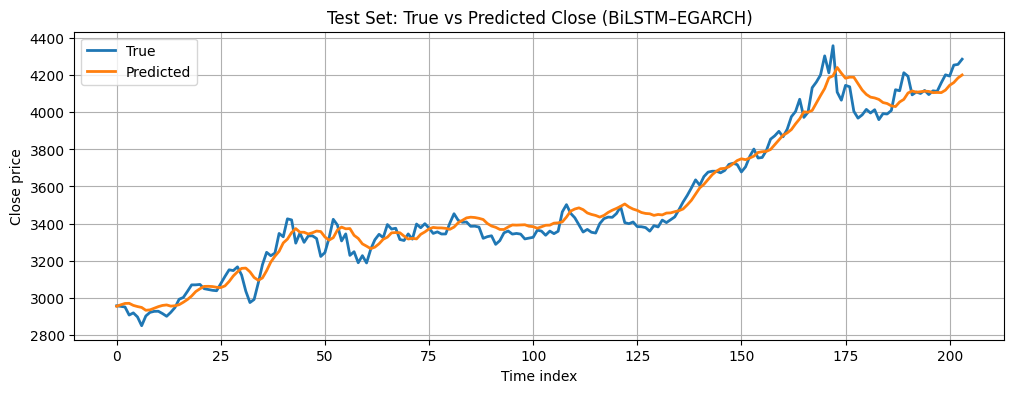

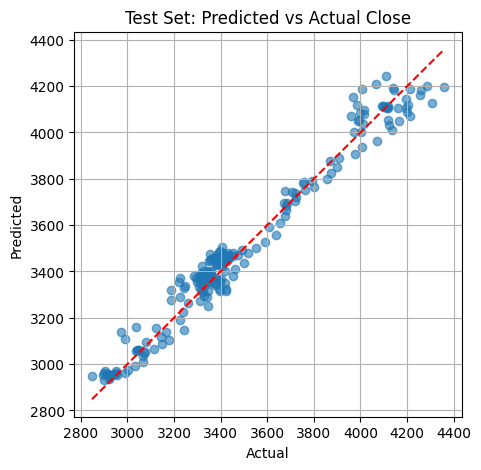

In [ ]:
# Line & Scatter plot for test set actual & predicted
import matplotlib.pyplot as plt

# Line plot
plt.figure(figsize=(12,4))
plt.plot(y_true_test, label="True", linewidth=2)
plt.plot(y_pred_test, label="Predicted", linewidth=2)
plt.title("Test Set: True vs Predicted Close (BiLSTM–EGARCH)")
plt.xlabel("Time index")
plt.ylabel("Close price")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(5,5))
plt.scatter(y_true_test, y_pred_test, alpha=0.6)
mn, mx = min(y_true_test.min(), y_pred_test.min()), max(y_true_test.max(), y_pred_test.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.title("Test Set: Predicted vs Actual Close")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()


In [ ]:
#line plots for Test/validatiion/training
# ===== Bulk predictions (scaled) =====
y_pred_tr_scaled  = best_model.predict(X_tr, verbose=0)
y_pred_val_scaled = best_model.predict(X_val, verbose=0)
y_pred_te_scaled  = best_model.predict(X_te, verbose=0)

# ===== Inverse scaling =====
y_pred_tr  = y_scaler.inverse_transform(y_pred_tr_scaled)
y_pred_val = y_scaler.inverse_transform(y_pred_val_scaled)
y_pred_te  = y_scaler.inverse_transform(y_pred_te_scaled)

y_true_tr  = y_scaler.inverse_transform(y_tr)
y_true_val = y_scaler.inverse_transform(y_val)
y_true_te  = y_scaler.inverse_transform(y_te)

# ===== Flatten for plotting =====
y_pred_tr  = y_pred_tr.ravel()
y_pred_val = y_pred_val.ravel()
y_pred_te  = y_pred_te.ravel()

y_true_tr  = y_true_tr.ravel()
y_true_val = y_true_val.ravel()
y_true_te  = y_true_te.ravel()


In [ ]:
import matplotlib.pyplot as plt

def plot_line(y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label="True", linewidth=2)
    plt.plot(y_pred, label="Predicted", linewidth=2)
    plt.title(title)
    plt.xlabel("Time index")
    plt.ylabel("Gold Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


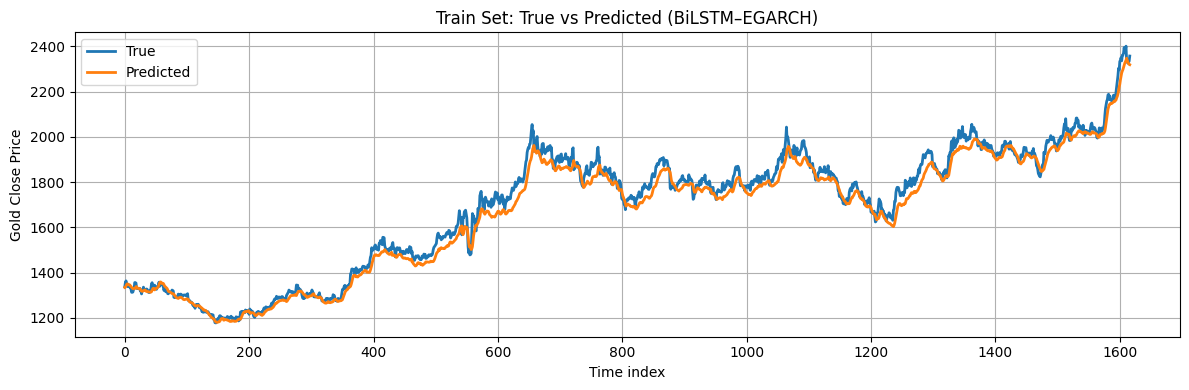

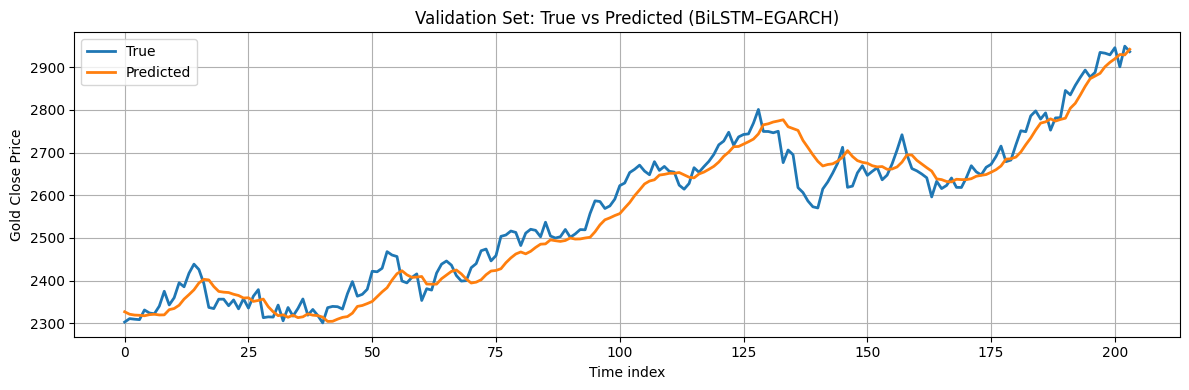

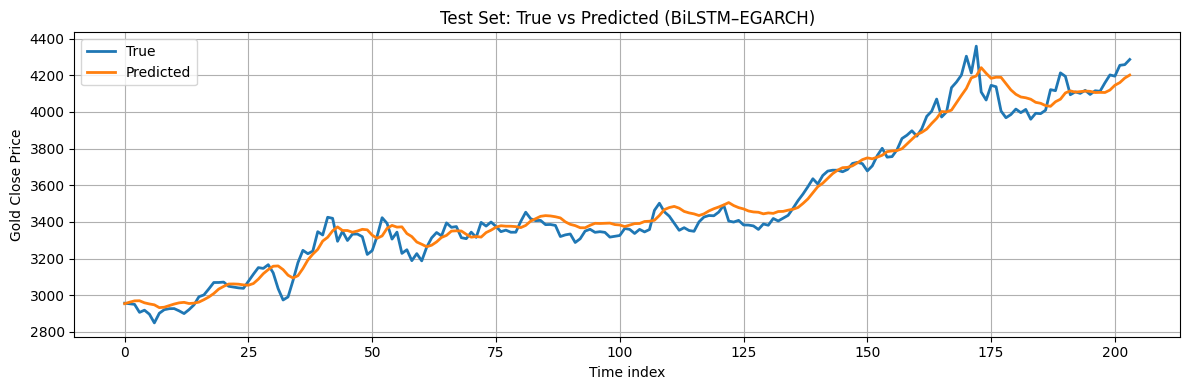

In [ ]:
# Train
plot_line(y_true_tr, y_pred_tr,
          "Train Set: True vs Predicted (BiLSTM–EGARCH)")

# Validation
plot_line(y_true_val, y_pred_val,
          "Validation Set: True vs Predicted (BiLSTM–EGARCH)")

# Test
plot_line(y_true_te, y_pred_te,
          "Test Set: True vs Predicted (BiLSTM–EGARCH)")


In [ ]:
#sctter plots for Test/validatiion/training
def plot_scatter(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual Close Price")
    plt.ylabel("Predicted Close Price")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

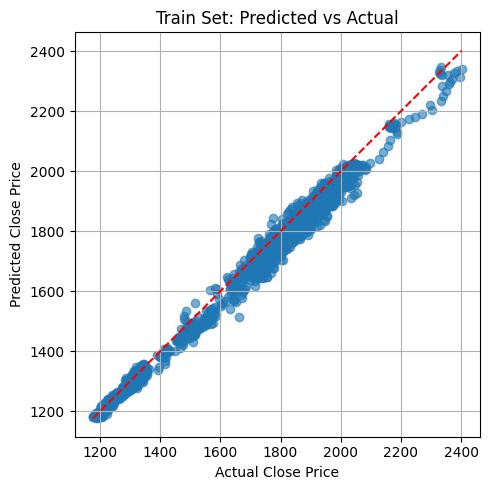

<Figure size 640x480 with 0 Axes>

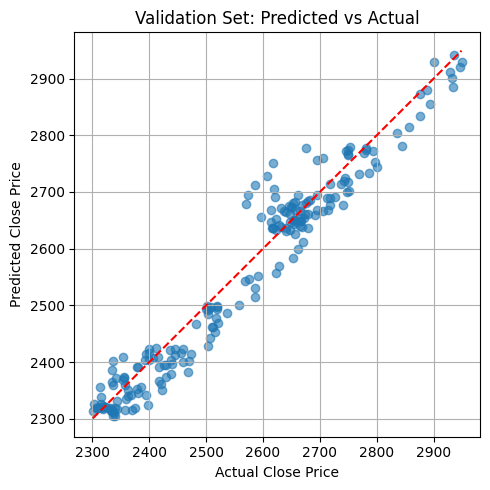

<Figure size 640x480 with 0 Axes>

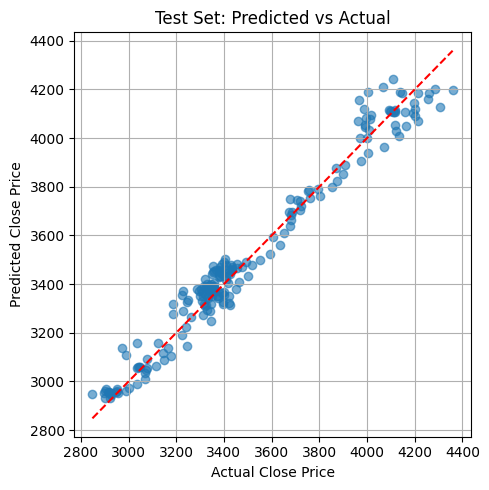

In [ ]:
# Train
plt.savefig('Train_Predicted vs Actual', dpi=300, bbox_inches='tight')
plot_scatter(y_true_tr, y_pred_tr,
             "Train Set: Predicted vs Actual")

# Validation
plt.savefig('Validation_Predicted vs Actual', dpi=300, bbox_inches='tight')
plot_scatter(y_true_val, y_pred_val,

             "Validation Set: Predicted vs Actual")

# Test
plt.savefig('Test_Predicted vs Actual', dpi=300, bbox_inches='tight')

plot_scatter(y_true_te, y_pred_te,
             "Test Set: Predicted vs Actual")


In [ ]:
#Buy/sell signal generation
signal_out = generate_signal_from_pipeline(
    model=best_model,
    df=Gold_df,
    feature_cols=feature_cols,
    X_scaler=X_scaler,
    y_scaler=y_scaler,
    forecast_fn=forecast_next_day_close,
    k=0.25
)

print(f"Today Close (P_t): {signal_out['today_close']:.2f}")
print(f"Predicted Next Close (P̂_t+1): {signal_out['pred_next_close']:.2f}")
print(f"Predicted Change (Δ): {signal_out['delta']:.2f}")
print(f"Threshold (τ = {signal_out['k']}×MAE): {signal_out['tau']:.2f}")
print(f"Direction: {signal_out['direction']}")
print(f"Signal: {signal_out['signal']}")
print(f"Window size used: {signal_out['window_size_used']}")
print(f"MAE used: {signal_out['mae_used']:.4f}")


Today Close (P_t): 4286.80
Predicted Next Close (P̂_t+1): 4217.19
Predicted Change (Δ): -69.61
Threshold (τ = 0.25×MAE): 13.20
Direction: DOWN
Signal: SELL
Window size used: 14
MAE used: 52.7919


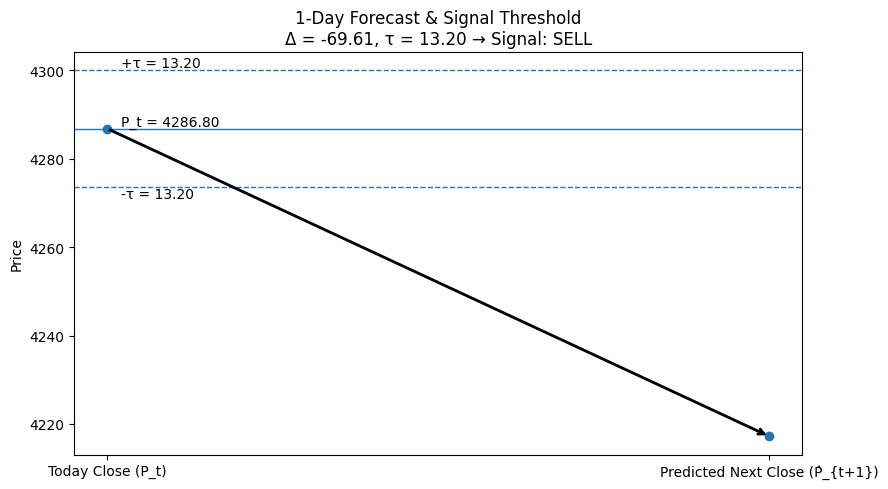

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_visual(close_t: float, pred_close_t1: float, mae: float, k: float = 0.25,
                       title: str = "1-Day Forecast & Signal Threshold"):
    close_t = float(close_t)
    pred_close_t1 = float(pred_close_t1)
    mae = float(mae)

    delta = pred_close_t1 - close_t
    tau = k * mae

    if delta > tau:
        signal = "BUY"
    elif delta < -tau:
        signal = "SELL"
    else:
        signal = "HOLD"

    x = np.array([0, 1])
    y = np.array([close_t, pred_close_t1])

    plt.figure(figsize=(9, 5))
    plt.plot(x, y, marker='o')
    plt.xticks([0, 1], ["Today Close (P_t)", "Predicted Next Close (P̂_{t+1})"])
    plt.ylabel("Price")

    # Threshold band around today's close
    plt.axhline(close_t + tau, linestyle='--', linewidth=1)
    plt.axhline(close_t - tau, linestyle='--', linewidth=1)
    plt.axhline(close_t, linestyle='-', linewidth=1)

    plt.text(0.02, close_t + tau, f"+τ = {tau:.2f}", va='bottom')
    plt.text(0.02, close_t - tau, f"-τ = {tau:.2f}", va='top')
    plt.text(0.02, close_t, f"P_t = {close_t:.2f}", va='bottom')

    plt.title(f"{title}\nΔ = {delta:.2f}, τ = {tau:.2f} → Signal: {signal}")

    plt.annotate("",
                 xy=(1, pred_close_t1),
                 xytext=(0, close_t),
                 arrowprops=dict(arrowstyle="->", linewidth=2))

    plt.tight_layout()
    plt.show()

# Example (replace with your pipeline values)
plot_signal_visual(close_t=4286.80, pred_close_t1=4217.1948, mae=52.7919, k=0.25)



In [ ]:
best_model.save("BiLSTM_EGARCH_seed83472.h5")
print("Model saved!")

Model saved!


In [ ]:

from sklearn.metrics import r2_score

# y_true and y_pred are already in original price scale
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R^2 :", r2)

Test MAE : 52.79185508578435
Test RMSE: 65.98441782327622
Test R^2 : 0.9694176640666385


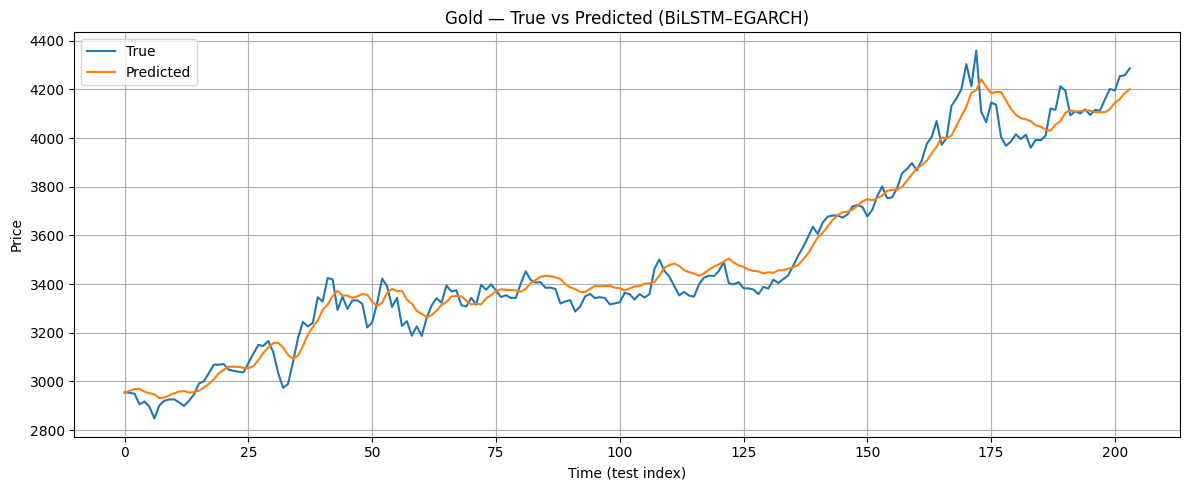

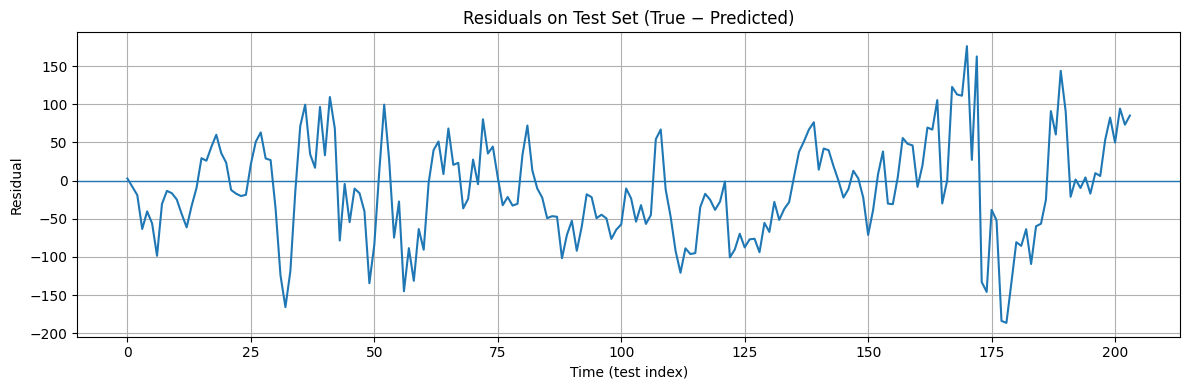

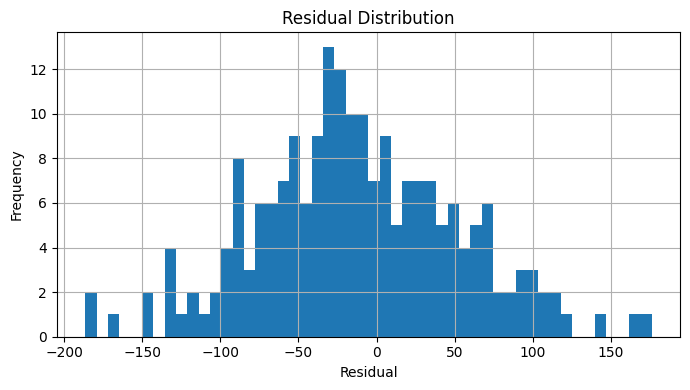

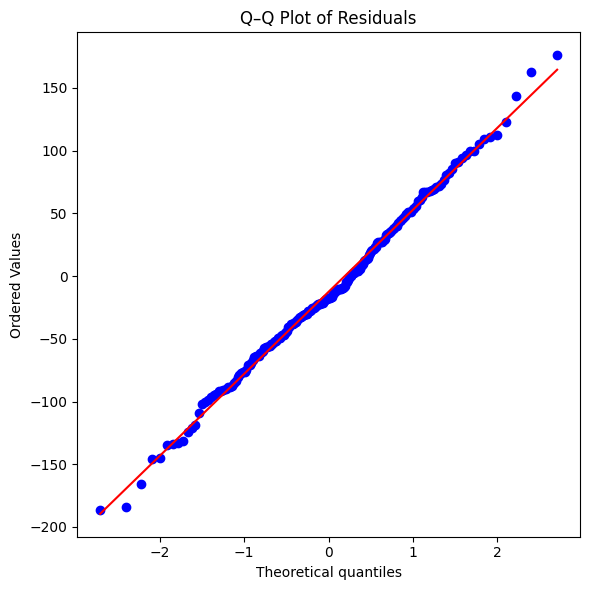

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Ensure 1D arrays ---
y_true_ = np.asarray(y_true).ravel()
y_pred_ = np.asarray(y_pred).ravel()
resid   = y_true_ - y_pred_

# --- Plot 1: True vs Predicted ---
plt.figure(figsize=(12,5))
plt.plot(y_true_, label="True")
plt.plot(y_pred_, label="Predicted")
plt.title("Gold — True vs Predicted (BiLSTM–EGARCH)")
plt.xlabel("Time (test index)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Residuals over time ---
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.axhline(0, linewidth=1)
plt.title("Residuals on Test Set (True − Predicted)")
plt.xlabel("Time (test index)")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.savefig('Residual.png', dpi=300, bbox_inches='tight')

plt.show()

# --- Plot 3: Residual histogram ---
plt.figure(figsize=(7,4))
plt.hist(resid, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 4: Q–Q plot (normality check) ---
plt.figure(figsize=(6,6))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.tight_layout()
plt.show()


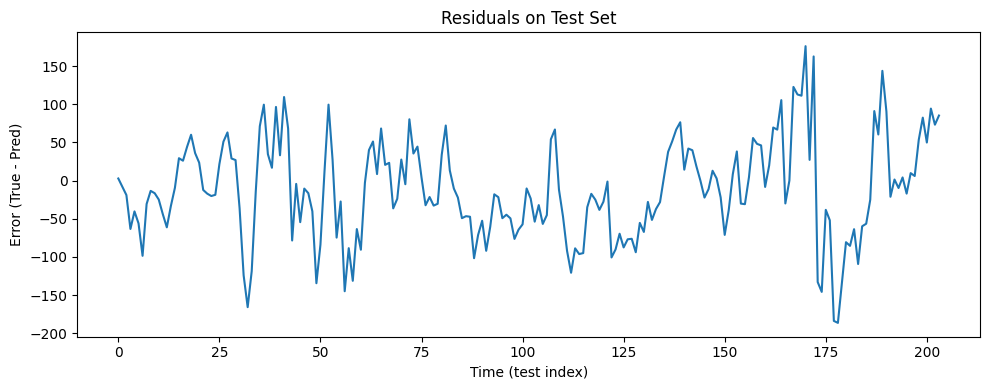

In [ ]:
#residaul for test set
residuals = (y_true - y_pred).ravel()

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals on Test Set")
plt.xlabel("Time (test index)")
plt.ylabel("Error (True - Pred)")
plt.tight_layout()
plt.show()

**The following section conducts model interpretability analysis using SHAP (SHapley Additive exPlanations).**

In [ ]:
import numpy as np

# Use the same test sequences you already created: X_te, y_te
# X_te shape: (n_test, 14, 3)

# Aggregate each 14-day window with a simple mean over time
X_te_summary = X_te.mean(axis=1)   # shape: (n_test, 3)
print("X_te_summary shape:", X_te_summary.shape)

# Get the BiLSTM predictions (this is what we want to explain)
y_pred_scaled = best_model.predict(X_te, verbose=0)
y_pred = y_scaler.inverse_transform(y_pred_scaled)  # back to price scale
y_pred = y_pred.ravel()
print("y_pred shape:", y_pred.shape)

X_te_summary shape: (204, 3)
y_pred shape: (204,)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

surrogate = GradientBoostingRegressor(random_state=0)
surrogate.fit(X_te_summary, y_pred)

print("Surrogate R^2 on test summary features:",
      surrogate.score(X_te_summary, y_pred))

Surrogate R^2 on test summary features: 0.9997196922825123


In [ ]:
import shap

# SHAP expects 2D: (samples, features) – that's exactly what X_te_summary is.
background = X_te_summary[:50]       # a subset as background
X_explain  = X_te_summary            # explain all test samples or a subset

explainer = shap.KernelExplainer(surrogate.predict, background)
shap_values = explainer.shap_values(X_explain, nsamples=200)

print("SHAP shape:", np.array(shap_values).shape)  # (n_samples, 3)

  0%|          | 0/204 [00:00<?, ?it/s]

SHAP shape: (204, 3)


In [ ]:
abs_shap = np.abs(shap_values)
mean_abs_shap = abs_shap.mean(axis=0)  # (3,)

for name, val in zip(['Close_mean_14d', 'Vol_mean_14d', 'EGARCH_mean_14d'],
                     mean_abs_shap):
    print(f"{name}: mean |SHAP| = {val:.4f}")

Close_mean_14d: mean |SHAP| = 440.8654
Vol_mean_14d: mean |SHAP| = 5.4983
EGARCH_mean_14d: mean |SHAP| = 13.8967


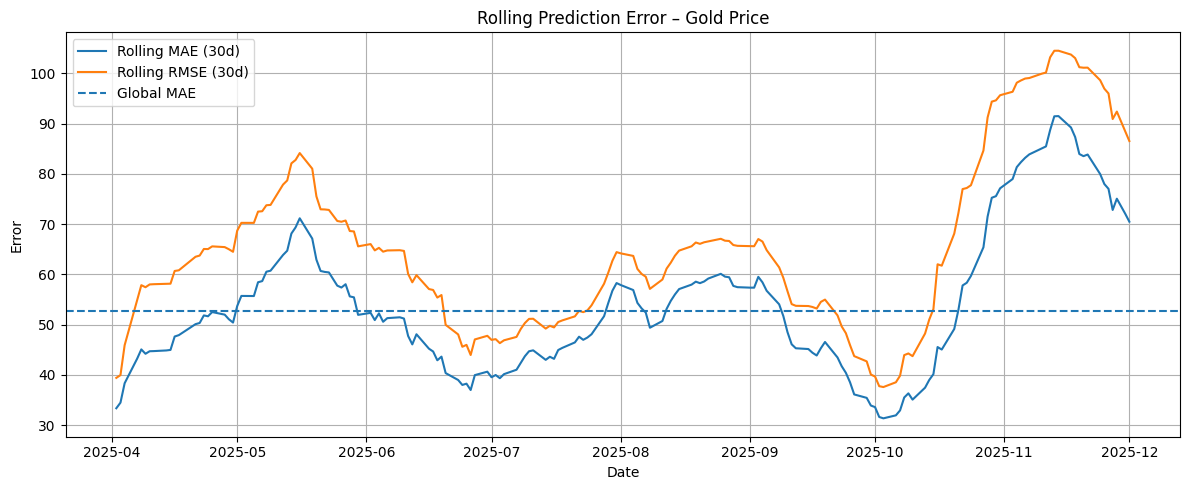

In [ ]:
#rolling RMSE for six months
plt.figure(figsize=(12,5))
plt.plot(df_test.index, df_test["rolling_mae"], label="Rolling MAE (30d)")
plt.plot(df_test.index, df_test["rolling_rmse"], label="Rolling RMSE (30d)")
plt.axhline(df_test["abs_error"].mean(), linestyle="--", label="Global MAE")
plt.title("Rolling Prediction Error – Gold Price")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def rolling_summary_table(df, window_days, step_days=21):
    """
    Summarize rolling error over time.
    window_days: e.g., 126 (6M) or 252 (1Y)
    step_days: how often to report (21 ≈ monthly, 5 ≈ weekly, 1 ≈ daily)
    """
    out = []
    n = len(df)

    # require rolling columns already computed: abs_error, sq_error
    for end in range(window_days, n + 1, step_days):
        sub = df.iloc[end - window_days:end]
        out.append({
            "Period Start": sub.index[0],
            "Period End": sub.index[-1],
            "Avg Price": sub["Close"].mean(),
            "Price Min": sub["Close"].min(),
            "Price Max": sub["Close"].max(),
            "MAE": sub["abs_error"].mean(),
            "RMSE": np.sqrt(sub["sq_error"].mean()),
            "N": len(sub)
        })

    return pd.DataFrame(out)

# --- make sure you have df_eval aligned and errors computed ---
df_eval["abs_error"] = np.abs(df_eval["y_pred"] - df_eval["y_true"])
df_eval["sq_error"]  = (df_eval["y_pred"] - df_eval["y_true"])**2

# 6-month rolling, reported monthly
table_6m_monthly = rolling_summary_table(df_eval, window_days=126, step_days=21)
table_6m_monthly


,Period Start,Period End,Avg Price,Price Min,Price Max,MAE,RMSE,N
0,2025-02-20,2025-08-14,3252.776270,2848.5,3501.8,49.212874,60.103437,126
1,2025-03-21,2025-09-12,3347.868492,2973.6,3686.4,50.480742,61.143109,126
2,2025-04-22,2025-10-13,3466.616111,3187.2,4133.0,47.719245,57.660756,126
3,2025-05-21,2025-11-11,3598.591508,3287.6,4359.4,54.081025,66.843416,126


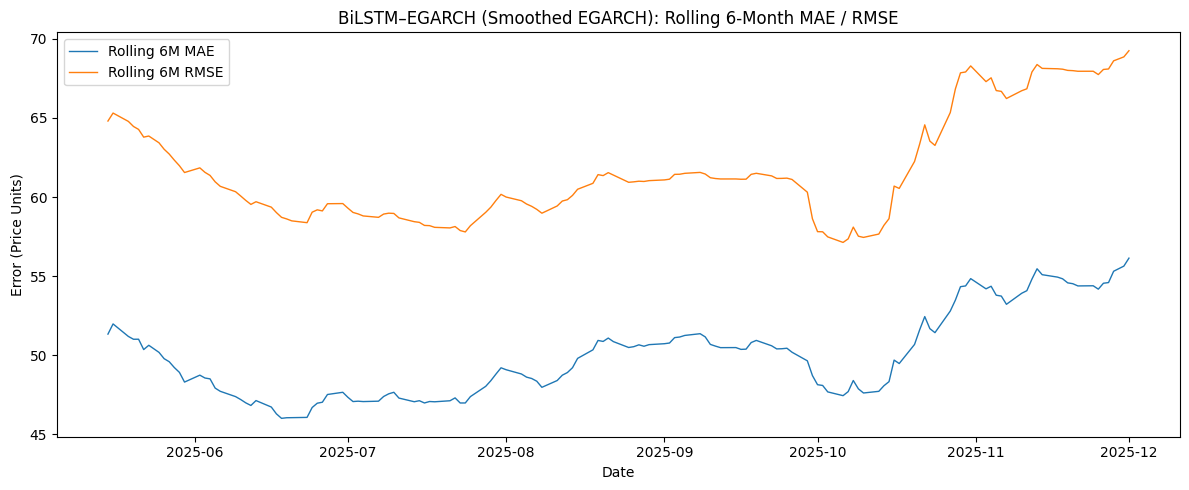

In [ ]:
import matplotlib.pyplot as plt

# If your rolling df has a different name, replace `roll` accordingly
plot_df = roll.dropna(subset=["rolling_mae_6m", "rolling_rmse_6m"]).copy()

plt.figure(figsize=(12, 5))
plt.plot(plot_df.index, plot_df["rolling_mae_6m"], linewidth=1, label="Rolling 6M MAE")
plt.plot(plot_df.index, plot_df["rolling_rmse_6m"], linewidth=1, label="Rolling 6M RMSE")
plt.title("BiLSTM–EGARCH (Smoothed EGARCH): Rolling 6-Month MAE / RMSE")
plt.xlabel("Date")
plt.ylabel("Error (Price Units)")
plt.legend()
plt.tight_layout()
plt.show()


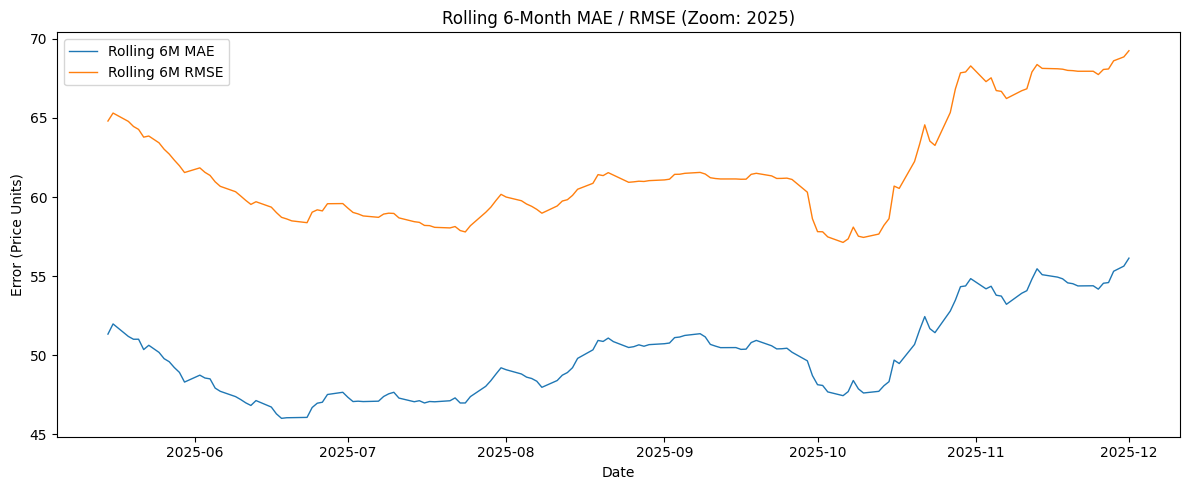

In [ ]:
zoom = plot_df.loc["2025-01-01":"2025-12-31"]

plt.figure(figsize=(12, 5))
plt.plot(zoom.index, zoom["rolling_mae_6m"], linewidth=1, label="Rolling 6M MAE")
plt.plot(zoom.index, zoom["rolling_rmse_6m"], linewidth=1, label="Rolling 6M RMSE")
plt.title("Rolling 6-Month MAE / RMSE (Zoom: 2025)")
plt.xlabel("Date")
plt.ylabel("Error (Price Units)")
plt.legend()
plt.tight_layout()
plt.savefig('Rolling_ema .png', dpi=300, bbox_inches='tight')
plt.show()
